In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from scipy import ndimage
import pandas as pd

from sklearn.metrics import plot_confusion_matrix, confusion_matrix, f1_score, accuracy_score, recall_score

from tensorflow.keras import models, layers, metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array

from PIL import Image


from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, \
Activation, Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import LeakyReLU

import os

In [3]:
base_dir='../data/chest_xray/'

train_path = '../data/chest_xray/train'

validation_path = '../data/chest_xray/val'

test_path = '../data/chest_xray/test'

full_train_path = '../data/chest_xray/full_train'

##paths to different folders and types of data

In [4]:
train_pneumonia=os.listdir('../data/chest_xray/train/PNEUMONIA/')
train_normal=os.listdir('../data/chest_xray/train/NORMAL/')
val_dir_normal=os.listdir('../data/chest_xray/val/NORMAL/')
test_dir_normal=os.listdir('../data/chest_xray/test/NORMAL/')
val_dir_pneumonia=os.listdir('../data/chest_xray/val/PNEUMONIA/')
test_dir_pneumonia=os.listdir('../data/chest_xray/test/PNEUMONIA/')


##trying out combining training and validation sets and using a validation ratio when fitting models
full_train_pneumonia = os.listdir('../data/chest_xray/full_train/PNEUMONIA')
full_train_normal = os.listdir('../data/chest_xray/full_train/NORMAL')


##list object containing 'NORMAL' & 'PNEUMONIA'
label_string = os.listdir('../data/chest_xray/train')

In [5]:
# Greyscale distribution histogram - done, Jamie
# Class distribution - heavily weighted towards positive class (pneumonia) - done, Jamie
# Address class imbalance - incorporate flipped 0-class images - Rachel wrote a function for this
# Mean values for negative and positive classes - Svitlana 
# Look for outliers
# Look at subracting the pixel mean
# Apply matrix transformations to further define images - 
# Data Augmentation - Svitlana will make an attempt

In [6]:
print("Train set w/ pneumonia: ", len(train_pneumonia))
print("Train set normal: ", len(train_normal))
print("Validation set w/ pneumonia: ", len(val_dir_pneumonia))
print("Validation set normal: ", len(val_dir_normal))
print("Test set w/ pneumonia: ", len(test_dir_pneumonia))
print("Test set normal: ", len(test_dir_normal))
print("Full training set w/pneumonia (combined w/validation): ", len(full_train_pneumonia))
print("Full training set normal (combined w/validation): ", len(full_train_normal))

Train set w/ pneumonia:  2144
Train set normal:  699
Validation set w/ pneumonia:  1739
Validation set normal:  650
Test set w/ pneumonia:  390
Test set normal:  234
Full training set w/pneumonia (combined w/validation):  3883
Full training set normal (combined w/validation):  1349


In [7]:
2144+699, 1739+650, 390+234, 3883+1349 ##total values for batch sizes

(2843, 2389, 624, 5232)

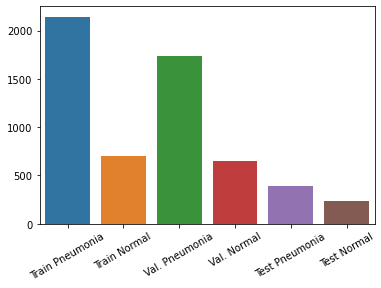

In [8]:
labels = ['Train Pneumonia', 'Train Normal', 'Val. Pneumonia', 'Val. Normal', 'Test Pneumonia', 'Test Normal']
dist = sns.barplot(x=labels, 
           y=[len(train_pneumonia), len(train_normal), len(val_dir_pneumonia), len(val_dir_normal), len(test_dir_pneumonia), len(test_dir_normal)],)

dist.set_xticklabels(labels = labels, rotation = 30);

There is a class imbalance between the positive class (pneumonia) and negative class (normal), which could potentially pose a challenge when training the model. We will be experimenting with data augmentation should the need arise.

In [9]:
#loading images for training set - pneumonia

plt.suptitle("Patients with Pneumonia")
for i in range(0,4):
    img = train_pneumonia[i]
    img = load_img(train_path+'/PNEUMONIA/'+img)
#   plt.imshow(img)
#   plt.show()

<Figure size 432x288 with 0 Axes>

In [10]:
#loading images for training set - normal

plt.suptitle("Normal Patients")
for i in range(0,4):
    img = train_normal[i]
    img = load_img(train_path+'/NORMAL/'+img)
#    plt.imshow(img)
#    plt.show()

<Figure size 432x288 with 0 Axes>

In [11]:
train_gen = ImageDataGenerator(rescale = 1/255.).flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 batch_size=2843,
                                                 color_mode = 'grayscale',                
                                                 class_mode='binary')

val_gen = ImageDataGenerator(rescale = 1/255.).flow_from_directory(validation_path,
                                            target_size=(224, 224),
                                            shuffle=True,
                                            batch_size=2389,
                                            color_mode = 'grayscale',                      
                                            class_mode='binary')

test_gen = ImageDataGenerator(rescale = 1/255.).flow_from_directory(test_path,
                                            target_size=(224, 224),
                                            batch_size=624,
                                            color_mode = 'grayscale',                        
                                            class_mode='binary')

##Image generator object for full training folder
full_train_gen = ImageDataGenerator(rescale = 1/255.).flow_from_directory(full_train_path,
                                            target_size=(224, 224),
                                            batch_size=5232,
                                            color_mode = 'grayscale',                        
                                            class_mode='binary')

Found 2843 images belonging to 2 classes.
Found 2389 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


In [12]:
train_images, train_labels = next(train_gen)
val_images, val_labels = next(val_gen)
test_images, test_labels = next(test_gen)

##full training folder
full_train_images, full_train_labels = next(full_train_gen)

In [13]:
print("Train image shape:", train_images.shape, "train label shape:", train_labels.shape)
print("Val image shape:", val_images.shape, "val label shape:", val_labels.shape)
print("Test image shape:", test_images.shape, "test label shape:", test_labels.shape)

print("Full Train image shape:", full_train_images.shape, "full train label shape:", full_train_labels.shape)

Train image shape: (2843, 224, 224, 1) train label shape: (2843,)
Val image shape: (2389, 224, 224, 1) val label shape: (2389,)
Test image shape: (624, 224, 224, 1) test label shape: (624,)
Full Train image shape: (5232, 224, 224, 1) full train label shape: (5232,)


In [14]:
train_x = train_images.reshape(train_images.shape[0], -1)
val_x = val_images.reshape(val_images.shape[0], -1)
test_x = test_images.reshape(test_images.shape[0], -1)

full_train_x = full_train_images.reshape(full_train_images.shape[0], -1)

In [15]:
train_x.shape, val_x.shape, test_x.shape, full_train_x.shape

((2843, 50176), (2389, 50176), (624, 50176), (5232, 50176))

In [16]:
train_y = np.reshape(train_labels[:], (2843,1))
val_y = np.reshape(val_labels[:], (2389,1))
test_y = np.reshape(test_labels[:], (624,1))

##full training set labels
full_train_y = np.reshape(full_train_labels[:], (5232,1))

In [17]:
train_y.shape, val_y.shape, test_y.shape, full_train_y.shape

((2843, 1), (2389, 1), (624, 1), (5232, 1))

# FSM  
For a first simple model, I selected building a densely-connected network with one hidden layer to create a baseline expectation of performance. 

In [24]:
np.random.seed(42)


fsm = models.Sequential()
fsm.add(layers.Dense(12, activation='relu', input_shape=(50176,)))
fsm.add(layers.Dense(7, activation='relu'))
fsm.add(layers.Dense(1, activation='sigmoid'))

The first simple model will be using stochastic gradient descent and measuring both accuracy and recall - the model's overall performance and its ability to correctly predict the positive class.

In [25]:
np.random.seed(42) ##setting a random state for reproduceability

fsm.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics= (['accuracy'], metrics.Recall()))

%timeit
history = fsm.fit(train_x,
                    train_y,
                    epochs=25,
                    batch_size=32,
                    validation_data=(val_x, val_y))

Epoch 1/25
89/89 [==============================] - 1s 10ms/step - loss: 0.6833 - accuracy: 0.7460 - recall_5: 0.9869 - val_loss: 0.6427 - val_accuracy: 0.7279 - val_recall_5: 1.0000
Epoch 2/25
89/89 [==============================] - 1s 8ms/step - loss: 0.6176 - accuracy: 0.7541 - recall_5: 1.0000 - val_loss: 0.6141 - val_accuracy: 0.7279 - val_recall_5: 1.0000
Epoch 3/25
89/89 [==============================] - 1s 7ms/step - loss: 0.5914 - accuracy: 0.7541 - recall_5: 1.0000 - val_loss: 0.5988 - val_accuracy: 0.7279 - val_recall_5: 1.0000
Epoch 4/25
89/89 [==============================] - 1s 7ms/step - loss: 0.5766 - accuracy: 0.7541 - recall_5: 1.0000 - val_loss: 0.5911 - val_accuracy: 0.7279 - val_recall_5: 1.0000
Epoch 5/25
89/89 [==============================] - 1s 8ms/step - loss: 0.5683 - accuracy: 0.7541 - recall_5: 1.0000 - val_loss: 0.5874 - val_accuracy: 0.7279 - val_recall_5: 1.0000
Epoch 6/25
89/89 [==============================] - 1s 7ms/step - loss: 0.5636 - accuracy

In [31]:
fsm_preds = np.round(fsm.predict(train_x)).astype(int)

In [32]:
fsm_true = train_y

In [39]:
print(f'Confusion matrix:\n {confusion_matrix(train_y, fsm_preds)}\n')
print(f'F1 score: {f1_score(train_y, fsm_preds)}')
print(f'Recall: {recall_score(train_y, fsm_preds)}')
print(f'Accuracy: {accuracy_score(train_y, fsm_preds)}')

Confusion matrix:
 [[   0  699]
 [   0 2144]]

F1 score: 0.85983557248847
Recall: 1.0
Accuracy: 0.7541329581428069


Based off this first model, it's possible that the class imbalance may create issues further down the road. This model only predicted positive class, which is acceptable for maximizing recall but overall not a reliable model.

In [40]:
np.random.seed(42)

dense = models.Sequential()
dense.add(layers.Dense(12, activation='relu', input_shape=(50176,)))
dense.add(layers.Dense(7, activation='relu'))
dense.add(layers.Dense(1, activation='sigmoid'))


dense.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics= (['accuracy'], metrics.Recall()))


history = dense.fit(train_x,
                    train_y,
                    epochs=25,
                    batch_size=32,
                    validation_data=(val_x, val_y))

Epoch 1/25
89/89 [==============================] - 1s 13ms/step - loss: 1.1222 - accuracy: 0.7126 - recall_6: 0.9277 - val_loss: 0.6776 - val_accuracy: 0.7279 - val_recall_6: 1.0000
Epoch 2/25
89/89 [==============================] - 1s 11ms/step - loss: 0.6721 - accuracy: 0.7541 - recall_6: 1.0000 - val_loss: 0.6432 - val_accuracy: 0.7279 - val_recall_6: 1.0000
Epoch 3/25
89/89 [==============================] - 1s 11ms/step - loss: 0.6200 - accuracy: 0.7541 - recall_6: 1.0000 - val_loss: 0.6157 - val_accuracy: 0.7279 - val_recall_6: 1.0000
Epoch 4/25
89/89 [==============================] - 1s 11ms/step - loss: 0.5907 - accuracy: 0.7541 - recall_6: 1.0000 - val_loss: 0.5965 - val_accuracy: 0.7279 - val_recall_6: 1.0000
Epoch 5/25
89/89 [==============================] - 1s 12ms/step - loss: 0.5720 - accuracy: 0.7541 - recall_6: 1.0000 - val_loss: 0.5877 - val_accuracy: 0.7279 - val_recall_6: 1.0000
Epoch 6/25
89/89 [==============================] - 1s 11ms/step - loss: 0.5626 - acc

In [41]:
dense_preds = np.round(dense.predict(train_x)).astype(int)
dense_true = train_y
print(f'Confusion matrix:\n {confusion_matrix(dense_true, dense_preds)}\n')
print(f'F1 score: {f1_score(dense_true, dense_preds)}')
print(f'Recall: {recall_score(dense_true, dense_preds)}')
print(f'Accuracy: {accuracy_score(dense_true, dense_preds)}')

Confusion matrix:
 [[   0  699]
 [   0 2144]]

F1 score: 0.85983557248847
Recall: 1.0
Accuracy: 0.7541329581428069


# First CNN 

We implemented an early stopping callback in order to minimize time spent running each model - the metrics were set to measure minimal loss on the validation set with a 3-epoch tolerance.

In [65]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224 , 224, 1)))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(layers.Flatten())
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 3)
##instantiating early stopping with a 3-epoch tolerance for minimizing loss

In [66]:
cnn.compile(optimizer = 'sgd', 
              loss = 'binary_crossentropy', 
              metrics = (['accuracy'], metrics.Recall()))

In [70]:
cnn_hist = cnn.fit(train_images, train_labels, 
                     epochs = 25, 
                     batch_size = 64, 
                     validation_data=(val_images, val_y), 
                     callbacks = [es])

Epoch 1/25
45/45 [==============================] - 106s 2s/step - loss: 0.5384 - accuracy: 0.7415 - recall_14: 0.9767 - val_loss: 0.5281 - val_accuracy: 0.7279 - val_recall_14: 1.0000
Epoch 2/25
45/45 [==============================] - 105s 2s/step - loss: 0.4555 - accuracy: 0.7914 - recall_14: 0.9785 - val_loss: 0.4412 - val_accuracy: 0.8694 - val_recall_14: 0.9402
Epoch 3/25
45/45 [==============================] - 105s 2s/step - loss: 0.3860 - accuracy: 0.8410 - recall_14: 0.9459 - val_loss: 0.5811 - val_accuracy: 0.7388 - val_recall_14: 0.9994
Epoch 4/25
45/45 [==============================] - 106s 2s/step - loss: 0.3104 - accuracy: 0.8786 - recall_14: 0.9636 - val_loss: 0.4530 - val_accuracy: 0.7907 - val_recall_14: 0.7269
Epoch 5/25
45/45 [==============================] - 106s 2s/step - loss: 0.2788 - accuracy: 0.8941 - recall_14: 0.9506 - val_loss: 0.2363 - val_accuracy: 0.9050 - val_recall_14: 0.9511
Epoch 6/25
45/45 [==============================] - 106s 2s/step - loss: 0.

In [71]:
cnn_results = cnn.evaluate(train_images, train_y)

89/89 [==============================] - 18s 199ms/step - loss: 0.2118 - accuracy: 0.9180 - recall_14: 0.9939


In [72]:
cnn.evaluate(val_images, val_y)

75/75 [==============================] - 18s 246ms/step - loss: 0.2519 - accuracy: 0.8899 - recall_14: 0.9919


[0.2519053816795349, 0.8899120688438416, 0.9919493794441223]

In [73]:
cnn_hist.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x214399ea190>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.5384145379066467,
   0.4554627537727356,
   0.38596439361572266,
   0.31042760610580444,
   0.27878549695014954,
   0.2561520040035248,
   0.20758934319019318,
   0.20280122756958008,
   0.1899852603673935,
   0.19262845814228058,
   0.17463508248329163,
   0.1739427149295807,
   0.14892345666885376,
   0.14619478583335876],
  'accuracy': [0.7414702773094177,
   0.7914175391197205,
   0.8410130143165588,
   0.8786492943763733,
   0.8941259384155273,
   0.9032711982727051,
   0.9194512963294983,
   0.9236721992492676,
   0.9219134449958801,
   0.9247273802757263,
   0.9264861345291138,
   0.9317622184753418,
   0.9426661729812622,
   0.9451283812522888],
  'recall_14': [0.9766790866851807,
   0.9785447716712952,
   0.9458954930305481,
   0.9636194109916687,
   0.950559675693512,
   0.951492547988891

In [74]:
model_epochs = cnn_hist.epoch
model_recall_train = cnn_hist.history['recall_14']
model_recall_val = cnn_hist.history['val_recall_14']
model_accuracy_train = cnn_hist.history['accuracy']
model_accuracy_val = cnn_hist.history['val_accuracy']
model_loss_train = cnn_hist.history['loss']
model_loss_val = cnn_hist.history['val_loss']

## Plotting Metrics of First CNN

### Accuracy, Recall, Loss

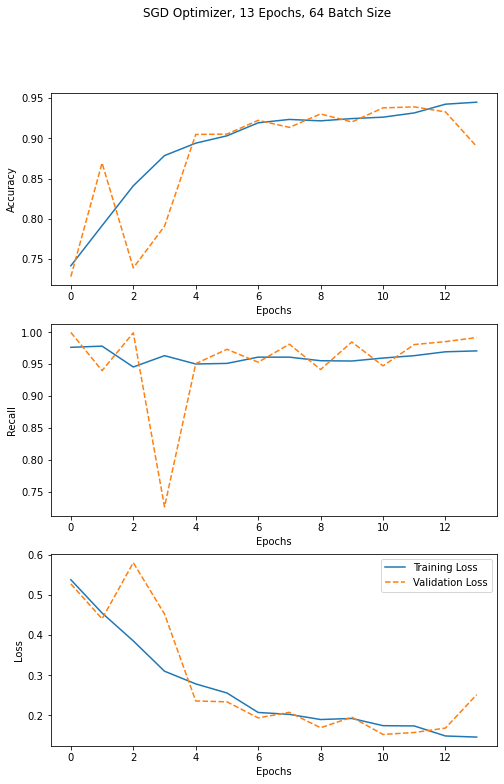

In [99]:
fig, axs = plt.subplots(3, figsize = (8,12))

plt.suptitle("SGD Optimizer, 13 Epochs, 64 Batch Size")

axs[0].plot(model_epochs, model_accuracy_train, label = 'Training Accuracy')
axs[0].plot(model_epochs, model_accuracy_val, linestyle = '--', label = 'Validation Accuracy')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")



axs[1].plot(model_epochs, model_recall_train, label = 'Training Recall')
axs[1].plot(model_epochs, model_recall_val, linestyle = '--', label = 'Validation Recall')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Recall")



axs[2].plot(model_epochs, model_loss_train, label = 'Training Loss')
axs[2].plot(model_epochs, model_loss_val, linestyle = '--', label = 'Validation Loss')
axs[2].set_xlabel("Epochs")
axs[2].set_ylabel("Loss")
plt.legend();

## CNN2

In [78]:
cnn2 = models.Sequential()
cnn2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224 , 224, 1)))
cnn2.add(layers.MaxPooling2D((2, 2)))

cnn2.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn2.add(layers.MaxPooling2D((2, 2)))

cnn2.add(layers.Flatten())
cnn2.add(layers.Dense(64, activation='relu'))
cnn2.add(layers.Dense(1, activation='sigmoid'))


cnn2.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=(['accuracy'], metrics.Recall()))

In [79]:
hist2 = cnn2.fit(train_images, train_labels, 
                 epochs = 25, 
                 batch_size = 64, 
                 validation_data=(val_images, val_y), 
                 callbacks = [es])

Epoch 1/25
45/45 [==============================] - 102s 2s/step - loss: 0.8887 - accuracy: 0.7633 - recall_15: 0.8172 - val_loss: 0.3000 - val_accuracy: 0.8686 - val_recall_15: 0.9109
Epoch 2/25
45/45 [==============================] - 103s 2s/step - loss: 0.2186 - accuracy: 0.9170 - recall_15: 0.9473 - val_loss: 0.5088 - val_accuracy: 0.7911 - val_recall_15: 0.7159
Epoch 3/25
45/45 [==============================] - 103s 2s/step - loss: 0.1802 - accuracy: 0.9342 - recall_15: 0.9515 - val_loss: 0.2847 - val_accuracy: 0.8891 - val_recall_15: 0.9327
Epoch 4/25
45/45 [==============================] - 103s 2s/step - loss: 0.1051 - accuracy: 0.9599 - recall_15: 0.9688 - val_loss: 0.2028 - val_accuracy: 0.9351 - val_recall_15: 0.9804
Epoch 5/25
45/45 [==============================] - 103s 2s/step - loss: 0.1013 - accuracy: 0.9659 - recall_15: 0.9790 - val_loss: 0.1560 - val_accuracy: 0.9468 - val_recall_15: 0.9350
Epoch 6/25
45/45 [==============================] - 105s 2s/step - loss: 0.

In [86]:
cnn2_train_results = cnn2.evaluate(train_images, train_labels)

89/89 [==============================] - 21s 236ms/step - loss: 0.0201 - accuracy: 0.9933 - recall_15: 0.9911


In [87]:
cnn2_val_results = cnn2.evaluate(val_images, val_labels)

75/75 [==============================] - 13s 174ms/step - loss: 0.2154 - accuracy: 0.9410 - recall_15: 0.9615


In [97]:
hist2.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x214348c5430>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.8886693120002747,
   0.21857082843780518,
   0.18016310036182404,
   0.10512540489435196,
   0.10134470462799072,
   0.0573425330221653,
   0.06857669353485107,
   0.041235484182834625],
  'accuracy': [0.7632782459259033,
   0.9169890880584717,
   0.9342244267463684,
   0.9599015116691589,
   0.9658811092376709,
   0.9795989990234375,
   0.9767850637435913,
   0.9848751425743103],
  'recall_15': [0.8171641826629639,
   0.9472947716712952,
   0.9514925479888916,
   0.96875,
   0.9790111780166626,
   0.9836753606796265,
   0.9836753606796265,
   0.9897388219833374],
  'val_loss': [0.2999967932701111,
   0.5088039040565491,
   0.2847336530685425,
   0.20275287330150604,
   0.15603876113891602,
   0.2028246819972992,
   0.18365809321403503,
   0.21538685262203217],
  'val_accuracy': [0.868564248085022,

In [100]:
cnn2_epochs = hist2.epoch
cnn2_recall_train = hist2.history['recall_15']
cnn2_recall_val = hist2.history['val_recall_15']
cnn2_accuracy_train = hist2.history['accuracy']
cnn2_accuracy_val = hist2.history['val_accuracy']
cnn2_loss_train = hist2.history['loss']
cnn2_loss_val = hist2.history['val_loss']

## Plotting Metrics of 2nd CNN

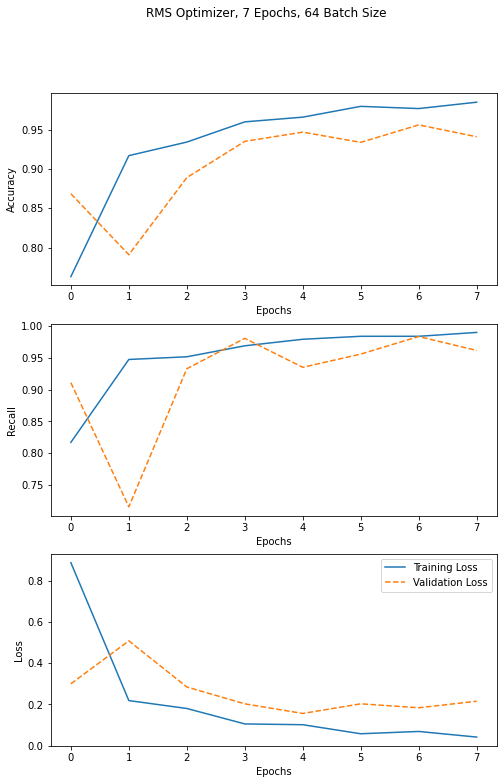

In [101]:
fig, axs = plt.subplots(3, figsize = (8,12))

plt.suptitle("RMS Optimizer, 7 Epochs, 64 Batch Size")

axs[0].plot(cnn2_epochs, cnn2_accuracy_train, label = 'Training Accuracy')
axs[0].plot(cnn2_epochs, cnn2_accuracy_val, linestyle = '--', label = 'Validation Accuracy')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")



axs[1].plot(cnn2_epochs, cnn2_recall_train, label = 'Training Recall')
axs[1].plot(cnn2_epochs, cnn2_recall_val, linestyle = '--', label = 'Validation Recall')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Recall")



axs[2].plot(cnn2_epochs, cnn2_loss_train, label = 'Training Loss')
axs[2].plot(cnn2_epochs, cnn2_loss_val, linestyle = '--', label = 'Validation Loss')
axs[2].set_xlabel("Epochs")
axs[2].set_ylabel("Loss")
plt.legend();

RMSProp (or root mean squared propagation) was more successful with similar metrics as the initial model, so we will proceed with using rmsprop as the optimizer.

## CNN3

We have included 'tanh' (or hyperbolic tangent) activation into this model in order to account for potential negative values.

In [103]:
cnn3 = models.Sequential()
cnn3.add(layers.Conv2D(32, (3, 3), activation='tanh',
                        input_shape=(224 , 224, 1)))
cnn3.add(layers.MaxPooling2D((2, 2)))

cnn3.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn3.add(layers.MaxPooling2D((2, 2)))

cnn3.add(layers.Flatten())
cnn3.add(layers.Dropout(.3))

cnn3.add(layers.Dense(64, activation='relu'))
cnn3.add(layers.Dense(1, activation='sigmoid'))


cnn3.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=(['accuracy'], metrics.Recall()))

In [107]:
np.random.seed(111)
hist3 = cnn3.fit(train_images, train_labels, 
                      epochs = 25, 
                      batch_size = 64, 
                      validation_data=(val_images, val_labels), 
                      callbacks = [es])

Epoch 1/25
45/45 [==============================] - 115s 3s/step - loss: 0.3322 - accuracy: 0.8590 - recall_17: 0.9212 - val_loss: 3.7497 - val_accuracy: 0.3181 - val_recall_17: 0.0633
Epoch 2/25
45/45 [==============================] - 111s 2s/step - loss: 0.3481 - accuracy: 0.8976 - recall_17: 0.9193 - val_loss: 0.3090 - val_accuracy: 0.8690 - val_recall_17: 0.9097
Epoch 3/25
45/45 [==============================] - 115s 3s/step - loss: 0.1732 - accuracy: 0.9377 - recall_17: 0.9585 - val_loss: 0.3624 - val_accuracy: 0.8719 - val_recall_17: 0.9856
Epoch 4/25
45/45 [==============================] - 115s 3s/step - loss: 0.1839 - accuracy: 0.9395 - recall_17: 0.9627 - val_loss: 0.1667 - val_accuracy: 0.9376 - val_recall_17: 0.9569
Epoch 5/25
45/45 [==============================] - 110s 2s/step - loss: 0.1553 - accuracy: 0.9705 - recall_17: 0.9823 - val_loss: 0.2002 - val_accuracy: 0.9293 - val_recall_17: 0.9856
Epoch 6/25
45/45 [==============================] - 112s 2s/step - loss: 0.

In [108]:
cnn3_train_results = cnn3.evaluate(train_images, train_labels)

89/89 [==============================] - 19s 214ms/step - loss: 0.0149 - accuracy: 0.9961 - recall_17: 0.9972


In [109]:
cnn3_val_results = cnn3.evaluate(val_images, val_labels)

75/75 [==============================] - 16s 219ms/step - loss: 0.1830 - accuracy: 0.9519 - recall_17: 0.9810


In [110]:
hist3.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x21432dcfbb0>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.3322272300720215,
   0.34811535477638245,
   0.17319852113723755,
   0.1838795393705368,
   0.15534324944019318,
   0.08123910427093506,
   0.05847295746207237,
   0.07819005101919174,
   0.049190703779459],
  'accuracy': [0.8589518070220947,
   0.8976433277130127,
   0.9377418160438538,
   0.9395005106925964,
   0.9704537391662598,
   0.9676398038864136,
   0.9753780961036682,
   0.9750263690948486,
   0.9813576936721802],
  'recall_17': [0.9211753606796265,
   0.919309675693512,
   0.9584888219833374,
   0.9626865386962891,
   0.9822761416435242,
   0.9785447716712952,
   0.9841417670249939,
   0.9860074520111084,
   0.9864738583564758],
  'val_loss': [3.7496514320373535,
   0.3089756369590759,
   0.3623555898666382,
   0.16673651337623596,
   0.2001986801624298,
   0.13301067054271698,
   0.8138

In [111]:
cnn3_epochs = hist3.epoch
cnn3_recall_train = hist3.history['recall_17']
cnn3_recall_val = hist3.history['val_recall_17']
cnn3_accuracy_train = hist3.history['accuracy']
cnn3_accuracy_val = hist3.history['val_accuracy']
cnn3_loss_train = hist3.history['loss']
cnn3_loss_val = hist3.history['val_loss']

## Plotting CNN3

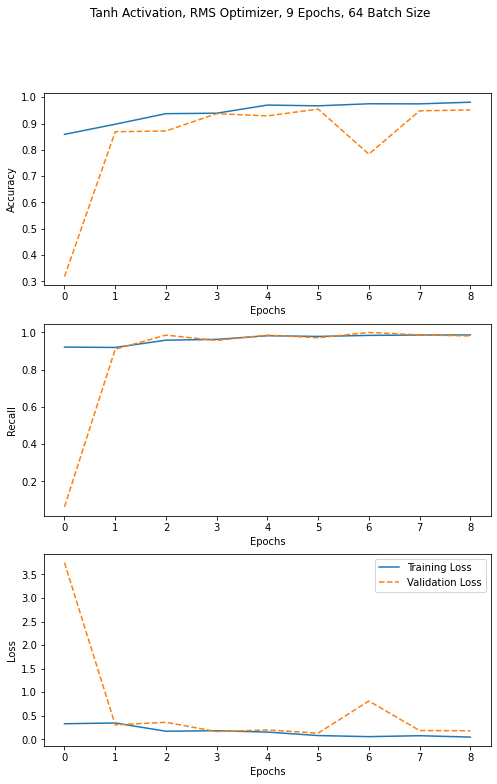

In [113]:
fig, axs = plt.subplots(3, figsize = (8,12))

plt.suptitle("Tanh Activation, RMS Optimizer, 9 Epochs, 64 Batch Size")

axs[0].plot(cnn3_epochs, cnn3_accuracy_train, label = 'Training Accuracy')
axs[0].plot(cnn3_epochs, cnn3_accuracy_val, linestyle = '--', label = 'Validation Accuracy')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")



axs[1].plot(cnn3_epochs, cnn3_recall_train, label = 'Training Recall')
axs[1].plot(cnn3_epochs, cnn3_recall_val, linestyle = '--', label = 'Validation Recall')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Recall")



axs[2].plot(cnn3_epochs, cnn3_loss_train, label = 'Training Loss')
axs[2].plot(cnn3_epochs, cnn3_loss_val, linestyle = '--', label = 'Validation Loss')
axs[2].set_xlabel("Epochs")
axs[2].set_ylabel("Loss")
plt.legend();

## CNN 4 - further fiddling
Introducing a Leaky ReLu activation layer.

In [114]:
cnn4 = models.Sequential()
cnn4.add(layers.Conv2D(32, (3, 3), activation='tanh',
                        input_shape=(224 , 224, 1)))
cnn4.add(layers.MaxPooling2D((2, 2)))

cnn4.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn4.add(layers.MaxPooling2D((2, 2)))


cnn4.add(LeakyReLU())
cnn4.add(layers.MaxPooling2D((2, 2), padding = 'same'))

cnn4.add(layers.Dropout(.3))
cnn4.add(layers.Flatten())

cnn4.add(layers.Dense(128, activation='relu'))
cnn4.add(layers.Dense(64, activation='relu'))
cnn4.add(layers.Dense(1, activation='sigmoid'))


cnn4.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=(['accuracy'], metrics.Recall()))

In [115]:
hist4 = cnn4.fit(train_images, train_labels, 
                 epochs = 25, batch_size = 64, 
                 validation_data=(val_images, val_labels), 
                 callbacks = [es])

Epoch 1/25
45/45 [==============================] - 110s 2s/step - loss: 0.5097 - accuracy: 0.7742 - recall_18: 0.8871 - val_loss: 0.3394 - val_accuracy: 0.8665 - val_recall_18: 0.8597
Epoch 2/25
45/45 [==============================] - 112s 2s/step - loss: 0.2317 - accuracy: 0.9145 - recall_18: 0.9501 - val_loss: 0.3493 - val_accuracy: 0.8585 - val_recall_18: 0.9264
Epoch 3/25
45/45 [==============================] - 114s 3s/step - loss: 0.1846 - accuracy: 0.9349 - recall_18: 0.9580 - val_loss: 0.2315 - val_accuracy: 0.9117 - val_recall_18: 0.9839
Epoch 4/25
45/45 [==============================] - 113s 3s/step - loss: 0.1392 - accuracy: 0.9479 - recall_18: 0.9636 - val_loss: 0.1962 - val_accuracy: 0.9213 - val_recall_18: 0.9287
Epoch 5/25
45/45 [==============================] - 114s 3s/step - loss: 0.1063 - accuracy: 0.9603 - recall_18: 0.9701 - val_loss: 0.3070 - val_accuracy: 0.9004 - val_recall_18: 0.9960
Epoch 6/25
45/45 [==============================] - 115s 3s/step - loss: 0.

In [116]:
cnn4_train_results = cnn4.evaluate(train_images, train_labels)

89/89 [==============================] - 20s 224ms/step - loss: 0.0063 - accuracy: 0.9993 - recall_18: 0.9991


In [117]:
cnn4_val_results = cnn4.evaluate(val_images, val_labels)

75/75 [==============================] - 15s 203ms/step - loss: 0.1679 - accuracy: 0.9607 - recall_18: 0.9810


In [119]:
hist4.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x2143c937ee0>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.5097469091415405,
   0.23170927166938782,
   0.18463905155658722,
   0.13921670615673065,
   0.10626121610403061,
   0.09074700623750687,
   0.07551465928554535,
   0.05876196175813675,
   0.044980842620134354,
   0.04035675898194313,
   0.02864663302898407,
   0.04375719279050827,
   0.013403422199189663,
   0.027464019134640694],
  'accuracy': [0.7741822004318237,
   0.9145268797874451,
   0.9349278807640076,
   0.947942316532135,
   0.9602532386779785,
   0.9704537391662598,
   0.9725642204284668,
   0.9792472720146179,
   0.9841716289520264,
   0.9876890778541565,
   0.9901512265205383,
   0.9859303832054138,
   0.9961308240890503,
   0.9926134347915649],
  'recall_18': [0.8871268630027771,
   0.9500932693481445,
   0.95802241563797,
   0.9636194109916687,
   0.9701492786407471,
   0.9790111780

In [120]:
cnn4_epochs = hist4.epoch
cnn4_recall_train = hist4.history['recall_18']
cnn4_recall_val = hist4.history['val_recall_18']
cnn4_accuracy_train = hist4.history['accuracy']
cnn4_accuracy_val = hist4.history['val_accuracy']
cnn4_loss_train = hist4.history['loss']
cnn4_loss_val = hist4.history['val_loss']

## CNN4 - Plotting Metrics

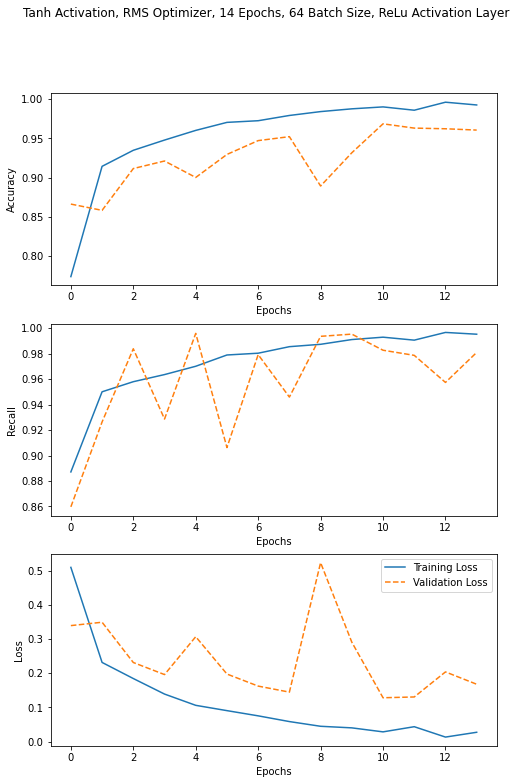

In [121]:
fig, axs = plt.subplots(3, figsize = (8,12))

plt.suptitle("Tanh Activation, RMS Optimizer, 14 Epochs, 64 Batch Size, ReLu Activation Layer")

axs[0].plot(cnn4_epochs, cnn4_accuracy_train, label = 'Training Accuracy')
axs[0].plot(cnn4_epochs, cnn4_accuracy_val, linestyle = '--', label = 'Validation Accuracy')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")



axs[1].plot(cnn4_epochs, cnn4_recall_train, label = 'Training Recall')
axs[1].plot(cnn4_epochs, cnn4_recall_val, linestyle = '--', label = 'Validation Recall')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Recall")



axs[2].plot(cnn4_epochs, cnn4_loss_train, label = 'Training Loss')
axs[2].plot(cnn4_epochs, cnn4_loss_val, linestyle = '--', label = 'Validation Loss')
axs[2].set_xlabel("Epochs")
axs[2].set_ylabel("Loss")
plt.legend();

Thus far, CNN4 has been the most succesful when measuring both recall and accuracy. We will use it to predict on the test set.

In [122]:
cnn_test_results = cnn4.evaluate(test_images, test_labels)

20/20 [==============================] - 3s 152ms/step - loss: 1.8930 - accuracy: 0.7324 - recall_18: 0.9897


In [123]:
y_pred = np.round(cnn4.predict(test_images)).astype(int)
y_true = np.round(test_labels).astype(int)

In [126]:
confusion_matrix(y_true, y_pred)

array([[ 71, 163],
       [  4, 386]], dtype=int64)

In [127]:
print(f'F1 score: {f1_score(y_true, y_pred)}')
print(f'Accuracy score: {accuracy_score(y_true, y_pred)}')
print(f'Recall score: {recall_score(y_true, y_pred)}')

F1 score: 0.8221512247071352
Accuracy score: 0.7323717948717948
Recall score: 0.9897435897435898


## Application of Transfer Learning

The test performed well in regard to recall, but did struggle with accuracy and a high rate of false positives. While in the scope of this problem this is not as much of an issue, a stronger model would help reduce the cost of misdiagnosis to healthcare companies as well as the emotional toll of repeated hospital visits to patients.

We have chosen to first apply a transfer learning method by using a convolutional base trained on the ImageNet dataset of over 1.2 million images. Because the images we are classifying are binary, we will set `include_top` to `False` as the top few layers of this model will not be useful for the task.  
We selected using the EfficientNet model due to its relatively low weight and high performance.

In [134]:
from tensorflow.keras.applications import EfficientNetB0

The images had to be converted into an rgb-esque format with 3 channels for them to work with the convolutional base's architecture, so we generated a new dataset to fit the requirement.

In [135]:
transfer_train_gen = ImageDataGenerator(rescale = 1/255.).flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 batch_size=2843,
                                                 color_mode = 'rgb',                
                                                 )

transfer_val_gen = ImageDataGenerator(rescale = 1/255.).flow_from_directory(validation_path,
                                            target_size=(224, 224),
                                            shuffle=True,
                                            batch_size=2389,
                                            color_mode = 'rgb',                      
                                            )

transfer_test_gen = ImageDataGenerator(rescale = 1/255.).flow_from_directory(test_path,
                                            target_size=(224, 224),
                                            batch_size=624,
                                            color_mode = 'rgb',                        
                                            )


Found 2843 images belonging to 2 classes.
Found 2389 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [136]:
conv_base = EfficientNetB0(include_top = False, 
                           weights = 'imagenet',
                           classes = 2)

In [137]:
transfer_model = models.Sequential()
transfer_model.add(conv_base)
transfer_model.add(layers.GlobalMaxPooling2D())

transfer_model.add(Dropout(.3))
transfer_model.add(layers.Flatten())
transfer_model.add(layers.Dense(64, activation='relu'))
transfer_model.add(layers.Dense(1, activation='sigmoid'))##the layers on top are similar to the final scratch model's layers

In [138]:
conv_base.trainable = False

for layer in transfer_model.layers:
    print(layer.name, layer.trainable)

print(len(transfer_model.trainable_weights))

efficientnetb0 False
global_max_pooling2d_1 True
dropout_4 True
flatten_11 True
dense_32 True
dense_33 True
4


In [139]:
transfer_model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=(['accuracy'], metrics.Recall()))
##instantiating Early Stopping with a 3-epoch tolerance for minimizing the validation loss

In [ ]:
np.random.seed(123)
conv_base_history = transfer_model.fit(transfer_train_gen,  
                                       epochs = 20, 
                                       batch_size = 32, 
                                       validation_data=transfer_val_gen, 
                                       callbacks = [es])

Epoch 1/20


In [92]:
conv_base_history.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x1f08f7017f0>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.8272767066955566,
   0.6617735624313354,
   0.5785691142082214,
   0.5739938616752625,
   0.5770297646522522],
  'accuracy': [0.6572375297546387,
   0.7097349762916565,
   0.7438837885856628,
   0.743628978729248,
   0.743628978729248],
  'recall_7': [0.8152844309806824, 0.9342014789581299, 1.0, 1.0, 1.0],
  'val_loss': [0.6259242296218872,
   0.5753017663955688,
   0.5760843753814697,
   0.5756241679191589,
   0.5759062767028809],
  'val_accuracy': [0.7377675771713257,
   0.7377675771713257,
   0.7377675771713257,
   0.7377675771713257,
   0.7377675771713257],
  'val_recall_7': [1.0, 1.0, 1.0, 1.0, 1.0]},
 'params': {'verbose': 1, 'epochs': 20, 'steps': 123},
 'epoch': [0, 1, 2, 3, 4]}

In [93]:
conv_epochs = conv_base_history.epoch

conv_loss = conv_base_history.history['loss']
conv_accuracy = conv_base_history.history['accuracy']
conv_recall = conv_base_history.history['recall_7']

conv_val_loss = conv_base_history.history['val_loss']
conv_val_accuracy = conv_base_history.history['val_accuracy']
conv_val_recall = conv_base_history.history['val_recall_7']

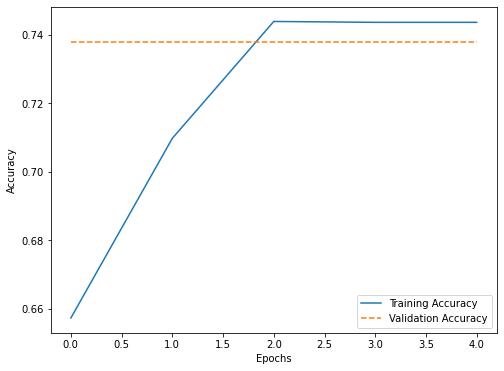

In [94]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(conv_epochs, conv_accuracy, label = 'Training Accuracy')
ax.plot(conv_epochs, conv_val_accuracy, linestyle = '--', label = 'Validation Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
plt.legend();

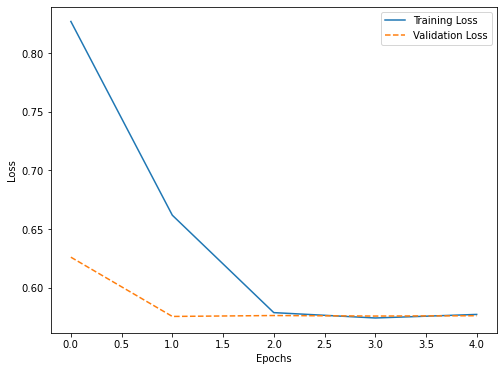

In [95]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(conv_epochs, conv_loss, label = 'Training Loss')
ax.plot(conv_epochs, conv_val_loss, linestyle = '--', label = 'Validation Loss')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
plt.legend();

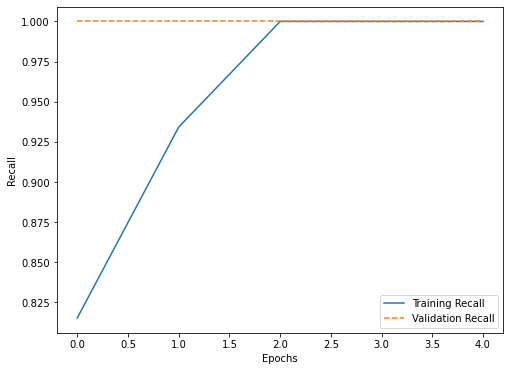

In [96]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(conv_epochs, conv_recall, label = 'Training Recall')
ax.plot(conv_epochs, conv_val_recall, linestyle = '--', label = 'Validation Recall')
ax.set_xlabel("Epochs")
ax.set_ylabel("Recall")
plt.legend();

In [97]:
base_train_results = transfer_model.evaluate(rgb_train_images, train_y_rgb)

164/164 [==============================] - 185s 1s/step - loss: 0.5710 - accuracy: 0.7422 - recall_7: 1.0000


In [98]:
np.random.seed(111)
y_test_preds = transfer_model.predict(rgb_test_images)
y_test_pred_rgb = np.round(y_test_preds).astype(int)

In [99]:
y_test_true_rgb = test_y_rgb.astype(int)
confusion_matrix(y_test_true_rgb, y_test_pred_rgb)

array([[  0, 234],
       [  0, 390]], dtype=int64)

This model only predicted the positive class, with no false negatives. As far as usefulness goes, this model does not fit the bill. The next step here may be using data augmentation. 

## Transfer Learning Attempt 2

In [299]:
cnn2_base = EfficientNetB0(include_top = False, 
                           weights = 'imagenet',
                           classes = 2, 
                           classifier_activation = 'tanh',
                           drop_connect_rate = .4)

In [300]:
cnn2_model = models.Sequential()
cnn2_model.add(cnn2_base)

cnn2_model.add(layers.GlobalMaxPooling2D())


cnn2_model.add(layers.Dropout(.4, name="dropout_out"))
cnn2_model.add(layers.Dense(256, activation="relu"))
cnn2_model.add(layers.Dense(128, activation="relu"))
cnn2_model.add(layers.Dense(64, activation="relu"))
cnn2_model.add(layers.Dense(2, activation="sigmoid", name="fc_out"))

In [284]:
cnn2_base.trainable = False

for layer in cnn2_model.layers:
    print(layer.name, layer.trainable)

print(len(cnn2_model.trainable_weights))

efficientnetb0 False
global_max_pooling2d_38 True
dropout_out True
dense_70 True
dense_71 True
dense_72 True
fc_out True
8


In [285]:
cnn2_model.summary()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_max_pooling2d_38 (Glo (None, 1280)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1280)              0         
_________________________________________________________________
dense_70 (Dense)             (None, 256)               327936    
_________________________________________________________________
dense_71 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_72 (Dense)             (None, 64)                8256      
_________________________________________________________________
fc_out (Dense)               (None, 2)               

In [290]:
cnn2_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=(['accuracy'], metrics.Recall()))

In [291]:
history = cnn2_model.fit(x = rgb_training_images, y = rgb_training_labels,  
    epochs = 20,
    batch_size = 16, 
    validation_data = (rgb_val_images, rgb_val_labels),
    verbose = 2, 
    callbacks = [es])

Epoch 1/20
178/178 - 249s - loss: 0.8839 - accuracy: 0.7541 - recall_36: 0.4372 - val_loss: 0.9231 - val_accuracy: 0.7279 - val_recall_36: 0.0000e+00
Epoch 2/20
178/178 - 231s - loss: 0.8870 - accuracy: 0.7541 - recall_36: 0.3757 - val_loss: 0.9328 - val_accuracy: 0.7279 - val_recall_36: 0.7279
Epoch 3/20
178/178 - 230s - loss: 0.8779 - accuracy: 0.7541 - recall_36: 0.4066 - val_loss: 0.8966 - val_accuracy: 0.7279 - val_recall_36: 0.0000e+00
Epoch 4/20
178/178 - 233s - loss: 0.8766 - accuracy: 0.7541 - recall_36: 0.3908 - val_loss: 0.8969 - val_accuracy: 0.7279 - val_recall_36: 0.0000e+00
Epoch 5/20
178/178 - 230s - loss: 0.8725 - accuracy: 0.7541 - recall_36: 0.4070 - val_loss: 0.8969 - val_accuracy: 0.7279 - val_recall_36: 0.0000e+00
Epoch 6/20
178/178 - 232s - loss: 0.8745 - accuracy: 0.7541 - recall_36: 0.3591 - val_loss: 0.8962 - val_accuracy: 0.7279 - val_recall_36: 0.0000e+00
Epoch 7/20
178/178 - 238s - loss: 0.8735 - accuracy: 0.7541 - recall_36: 0.4045 - val_loss: 0.9018 - val

In [292]:
train_results = cnn2_model.evaluate(rgb_val_images, rgb_val_labels)

75/75 [==============================] - 95s 1s/step - loss: 0.8965 - accuracy: 0.7279 - recall_36: 0.0000e+00


In [294]:
y_preds = np.round(cnn2_model.predict(rgb_training_images)).astype(int)
y_true = rgb_training_labels.astype(int)

0

In [295]:
confusion_matrix(y_true, y_preds)

ValueError: multilabel-indicator is not supported

## Using LIME to interpret meaningful parts of images

In [ ]:
#pip install lime

In [117]:
import os
import keras
from tensorflow.keras.applications import inception_v3 as inc_net
from tensorflow.keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from lime import lime_image
import time
from skimage.segmentation import mark_boundaries
from skimage.io import imread

In [118]:
path_list = []
for pic in test_dir_pneumonia:
    #print(pic)
    path_list.append('../data/chest_xray/test/PNEUMONIA/' + pic)
#creates a list of the file path foreach image in pneumonia

In [135]:
def transform_img_fn(path_list):
    """Takes in a list of file paths from images, loads the images, 
    transforms the images adn outputs arrays fro these images"""
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(224, 224, 3), color_mode = 'rgb')
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = np.divide(x, 255.0).astype('double')
        out.append(x)
    return np.vstack(out)

In [136]:
X = transform_img_fn(path_list)
#transforms all images and puts in list

#yhat_test = model5.predict(X)

In [110]:
yhat_min = yhat_test == min(yhat_test)

yhat_max = yhat_test == max(yhat_test)

np.where (yhat_test ==  min(yhat_test)), np.where(yhat_test == max(yhat_test))
#how to find hte minimum

((array([281], dtype=int64), array([0], dtype=int64)),
 (array([85], dtype=int64), array([0], dtype=int64)))

In [111]:
min_explainer = lime_image.LimeImageExplainer()

max_explainer = lime_image.LimeImageExplainer()
#instantiate explainer obj

In [ ]:
#min_explanation = min_explainer.explain_instance(###, model5.predict, top_labels=5, hide_color=0, num_samples=1000)

#max_explanation = max_explainer.explain_instance(test_images[85], model5.predict, top_labels=5, hide_color=0, num_samples=1000)

In [ ]:
min_temp, min_mask = min_explanation.get_image_and_mask(min_explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(min_temp / 2 + 0.5, min_mask))


max_temp, max_mask = max_explanation.get_image_and_mask(max_explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(max_temp / 2 + 0.5, max_mask))